In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
from torchvision import datasets,transforms
import torch.nn.functional as F
import sys
sys.path.append("../code/")
from dataloader import APPLIANCE_ORDER, get_train_test

In [28]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=7, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(20)

        self.conv2 = nn.Conv2d(20, 16, kernel_size=2, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 16, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(16)

        self.conv4 = nn.ConvTranspose2d(16, 16, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(16)

        self.conv5 = nn.ConvTranspose2d(16, 6, kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(6)

        self.conv6 = nn.ConvTranspose2d(6, 1, kernel_size=5, stride=1, padding=2) 
        
        self.act = nn.ReLU()
        
    # forward method
    def forward(self, input):
        
        e1 = self.conv1(input)
        bn1 = self.bn1(self.act(e1))
        e2 = self.bn2(self.act(self.conv2(bn1)))
#         e3 = self.bn3(self.conv3(e2))
        
#         e4 = self.bn4(self.conv4(e3))
        e5 = self.bn5(self.conv5(e2))
        e6 = self.conv6(e5)

        return e6

In [29]:
class CustomCNNDR(nn.Module):
    def __init__(self):
        super(CustomCNNDR, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=7, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(20)

        self.conv2 = nn.Conv2d(20, 16, kernel_size=2, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 64, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.ConvTranspose2d(64, 16, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(16)

        self.conv5 = nn.ConvTranspose2d(16, 6, kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(6)

        self.conv6 = nn.ConvTranspose2d(6, 1, kernel_size=5, stride=1, padding=2) 
        
        self.maxpool = nn.MaxPool2d(kernel_size=2,return_indices=True)
        self.avgpool = nn.AvgPool2d(kernel_size=2)
        self.unpool = nn.MaxUnpool2d(2)
        
        self.act = nn.ReLU()
        
    # forward method
    def forward(self, input):
        
        e1 = self.conv1(input)
        bn1 = self.bn1(self.act(e1))
        e2 = self.bn2(self.conv2(bn1))
#         e3 = self.bn3(self.conv3(e2))
        
#         e4 = self.bn4(self.conv4(e3))

        pred, indices = self.maxpool(e2)
        pred = self.unpool(pred, indices)
        
        e5 = self.bn5(self.conv5(pred))
        e6 = self.conv6(e5)

        return e6

In [30]:
class AppliancesCNN(nn.Module):
    def __init__(self, num_appliance):
        super(AppliancesCNN, self).__init__()
        self.num_appliance = num_appliance
        self.preds = {}
        self.order = ORDER
        for appliance in range(self.num_appliance):
#             if ORDER[appliance] in ['dr']:
                
#                 if cuda_av:
#                     setattr(self, "Appliance_" + str(appliance), CustomCNNDR().cuda())
#                 else:
#                     setattr(self, "Appliance_" + str(appliance), CustomCNNDR())
#             else:
            if cuda_av:
                setattr(self, "Appliance_" + str(appliance), CustomCNN().cuda())
            else:
                setattr(self, "Appliance_" + str(appliance), CustomCNN())

    def forward(self, *args):
        agg_current = args[0]
        flag = False
        if np.random.random() > args[1]:
            flag = True
        else:
            pass
        for appliance in range(self.num_appliance):
            self.preds[appliance] = getattr(self, "Appliance_" + str(appliance))(agg_current)
            if flag:
                agg_current = agg_current - self.preds[appliance]
            else:
                agg_current = agg_current - args[2 + appliance]

        return torch.cat([self.preds[a] for a in range(self.num_appliance)])

In [31]:
torch.manual_seed(0)
num_folds = 5
dataset = 5
fold_num = 3
lr = 0.1
train, test = get_train_test(dataset, num_folds=num_folds, fold_num=fold_num)

In [32]:
valid = train[int(0.8*len(train)):].copy()
train = train[:int(0.8 * len(train))].copy()

train_aggregate = train[:, 0, :, :].reshape(train.shape[0], 1, -1, 24)
valid_aggregate = valid[:, 0, :, :].reshape(valid.shape[0], 1, -1, 24)
test_aggregate = test[:, 0, :, :].reshape(test.shape[0], 1, -1, 24)

In [33]:
# ORDER = ['hvac', 'dr', 'fridge', 'dw', 'mw']
ORDER = ['residual', 'dr', 'fridge', 'hvac', 'dw', 'mw']
ORDER = ['fridge', 'residual', 'hvac', 'dr', 'dw', 'mw']
ORDER = ['hvac', 'dw', 'mw', 'fridge', 'residual', 'dr']
ORDER = ['hvac', 'residual', 'dr', 'dw', 'mw', 'fridge']
# ORDER = ['dw', 'mw', 'fridge', 'hvac', 'dr']
cuda_av = False
if torch.cuda.is_available():
    cuda_av = True

In [34]:
out_train = [None for temp in range(len(ORDER))]
for a_num, appliance in enumerate(ORDER):
    out_train[a_num] = Variable(
        torch.Tensor(train[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((train.shape[0], 1, -1, 24))))
    if cuda_av:
        out_train[a_num] = out_train[a_num].cuda()

out_valid = [None for temp in range(len(ORDER))]
for a_num, appliance in enumerate(ORDER):
    out_valid[a_num] = Variable(
        torch.Tensor(valid[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((valid.shape[0], 1, -1, 24))))
    if cuda_av:
        out_valid[a_num] = out_valid[a_num].cuda()
        
out_test = [None for temp in range(len(ORDER))]
for a_num, appliance in enumerate(ORDER):
    out_test[a_num] = Variable(
        torch.Tensor(test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((test.shape[0], 1, -1, 24))))
    if cuda_av:
        out_test[a_num] = out_test[a_num].cuda()

In [35]:
inp = Variable(torch.Tensor(train_aggregate).type(torch.FloatTensor),
               requires_grad=True)

inp = Variable(torch.Tensor(train_aggregate), requires_grad=False)
if cuda_av:
    inp = inp.cuda()

valid_inp = Variable(torch.Tensor(valid_aggregate), requires_grad=False)
if cuda_av:
    valid_inp = valid_inp.cuda()

test_inp = Variable(torch.Tensor(test_aggregate), requires_grad=False)
if cuda_av:
    test_inp = test_inp.cuda()

valid_pred = {}
train_pred = {}
test_pred = {}
test_losses = {}
valid_losses = {}

In [36]:
lr = 0.001

In [37]:
loss_func = nn.L1Loss()
model = AppliancesCNN(len(ORDER))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

if cuda_av:
    model = model.cuda()
    loss_func = loss_func.cuda()

In [38]:
valid_out = torch.cat([out_valid[appliance_num] for appliance_num, appliance in enumerate(ORDER)])
test_out = torch.cat([out_test[appliance_num] for appliance_num, appliance in enumerate(ORDER)])
train_out = torch.cat([out_train[appliance_num] for appliance_num, appliance in enumerate(ORDER)])

In [ ]:
p = 0
num_iterations = 10000
params = [inp, p]
for a_num, appliance in enumerate(ORDER):
    params.append(out_train[a_num])
        
for t in range(1, num_iterations+1):
  
    if cuda_av:
        train_out = train_out.cuda()

    
    pred = model(*params)

    optimizer.zero_grad()
    loss = loss_func(pred, train_out)
    if t % 100 == 0:

        if cuda_av:
            valid_inp = valid_inp.cuda()
        valid_params = [valid_inp, -2]
        for i in range(len(ORDER)):
            valid_params.append(None)
        valid_pr = model(*valid_params)
        valid_loss = loss_func(valid_pr, valid_out)

        if cuda_av:
            test_inp = test_inp.cuda()
        test_params = [test_inp, -2]
        for i in range(len(ORDER)):
            test_params.append(None)
        test_pr = model(*test_params)
        test_loss = loss_func(test_pr, test_out)

        test_losses[t] = test_loss.data[0]
        valid_losses[t] = valid_loss.data[0]
        # np.save("./baseline/p_50_loss")

        if t % 200 == 0:
            valid_pr = torch.clamp(valid_pr, min=0.)
            valid_pred[t] = valid_pr
            test_pr = torch.clamp(test_pr, min=0.)
            test_pred[t] = test_pr
            train_pr = pred
            train_pr = torch.clamp(train_pr, min=0.)
            train_pred[t] = train_pr

        print("Round:", t, "Training Error:", loss.data[0], "Validation Error:", valid_loss.data[0], "Test Error:", test_loss.data[0])

    loss.backward()
    optimizer.step()



Round: 100 Training Error: 354.4076843261719 Validation Error: 315.865966796875 Test Error: 351.9049072265625
Round: 200 Training Error: 348.7812194824219 Validation Error: 310.5641784667969 Test Error: 346.5971374511719
Round: 300 Training Error: 338.90203857421875 Validation Error: 301.593017578125 Test Error: 337.5229187011719
Round: 400 Training Error: 326.9839782714844 Validation Error: 291.0195007324219 Test Error: 326.51666259765625
Round: 500 Training Error: 314.1353759765625 Validation Error: 280.24847412109375 Test Error: 315.1833190917969
Round: 600 Training Error: 300.39251708984375 Validation Error: 268.40093994140625 Test Error: 303.27392578125
Round: 700 Training Error: 285.2790222167969 Validation Error: 255.5403594970703 Test Error: 290.4881896972656
Round: 800 Training Error: 268.8137512207031 Validation Error: 241.76548767089844 Test Error: 276.7635498046875
Round: 900 Training Error: 251.60537719726562 Validation Error: 228.28326416015625 Test Error: 262.90979003906

In [384]:
from sklearn.metrics import mean_absolute_error

train_fold = {}
for t in range(200, num_iterations + 1, 200):
    train_pred[t] = torch.split(train_pred[t], train_aggregate.shape[0])
    train_fold[t] = [None for x in range(len(ORDER))]
    if cuda_av:
        for appliance_num, appliance in enumerate(ORDER):
            train_fold[t][appliance_num] = train_pred[t][appliance_num].cpu().data.numpy().reshape(-1, 24)
    else:
        for appliance_num, appliance in enumerate(ORDER):
            train_fold[t][appliance_num] = train_pred[t][appliance_num].data.numpy().reshape(-1, 24)
            
valid_fold = {}
for t in range(200, num_iterations + 1, 200):

    valid_pred[t] = torch.split(valid_pred[t], valid_aggregate.shape[0])
    valid_fold[t] = [None for x in range(len(ORDER))]
    if cuda_av:
        for appliance_num, appliance in enumerate(ORDER):
            valid_fold[t][appliance_num] = valid_pred[t][appliance_num].cpu().data.numpy().reshape(-1, 24)
    else:
        for appliance_num, appliance in enumerate(ORDER):
            valid_fold[t][appliance_num] = valid_pred[t][appliance_num].data.numpy().reshape(-1, 24)

test_fold = {}
for t in range(200, num_iterations + 1, 200):

    test_pred[t] = torch.split(test_pred[t], test_aggregate.shape[0])
    test_fold[t] = [None for x in range(len(ORDER))]
    if cuda_av:
        for appliance_num, appliance in enumerate(ORDER):
            test_fold[t][appliance_num] = test_pred[t][appliance_num].cpu().data.numpy().reshape(-1, 24)
    else:
        for appliance_num, appliance in enumerate(ORDER):
            test_fold[t][appliance_num] = test_pred[t][appliance_num].data.numpy().reshape(-1, 24)

KeyError: 12600

In [385]:
# store ground truth of validation set
valid_gt_fold = [None for x in range(len(ORDER))]
for appliance_num, appliance in enumerate(ORDER):
    valid_gt_fold[appliance_num] = valid[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(
        valid_aggregate.shape[0],
        -1, 1).reshape(-1, 24)

test_gt_fold = [None for x in range(len(ORDER))]
for appliance_num, appliance in enumerate(ORDER):
    test_gt_fold[appliance_num] = test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(
        test_aggregate.shape[0],
        -1, 1).reshape(-1, 24)

train_gt_fold = [None for x in range(len(ORDER))]
for appliance_num, appliance in enumerate(ORDER):
    train_gt_fold[appliance_num] = train[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(
        train_aggregate.shape[0],
        -1, 1).reshape(-1, 24)

# calcualte the error of validation set
valid_error = {}
for t in range(200, num_iterations + 1, 200):
    valid_error[t] = {}
    for appliance_num, appliance in enumerate(ORDER):
        valid_error[t][appliance] = mean_absolute_error(valid_fold[t][appliance_num], valid_gt_fold[appliance_num])

test_error = {}
for t in range(200, num_iterations + 1, 200):
    test_error[t] = {}
    for appliance_num, appliance in enumerate(ORDER):
        test_error[t][appliance] = mean_absolute_error(test_fold[t][appliance_num], test_gt_fold[appliance_num])
        
train_error = {}
for t in range(200, num_iterations + 1, 200):
    train_error[t] = {}
    for appliance_num, appliance in enumerate(ORDER):
        train_error[t][appliance] = mean_absolute_error(train_fold[t][appliance_num], train_gt_fold[appliance_num])


KeyError: 10200

In [386]:
import pandas as pd
pd.DataFrame(test_error)

,200,400,600,800,1000,1200,1400,1600,1800,2000,...,8200,8400,8600,8800,9000,9200,9400,9600,9800,10000
dr,83.055160,83.054535,83.038774,83.026252,82.994378,82.988488,82.983354,82.985285,82.991420,83.001402,...,83.017957,83.017487,83.017936,83.021281,83.017185,83.016916,83.014621,83.011654,83.012503,83.015049
dw,20.595314,20.593028,20.592587,20.592642,20.592157,20.592192,20.592121,20.592540,20.592253,20.592146,...,20.592149,20.592141,20.592555,20.592222,20.592096,20.592085,20.592922,20.592083,20.592268,20.592163
fridge,32.752637,33.363849,34.618016,35.005537,34.378178,35.126743,35.802170,35.855893,36.260577,35.726298,...,36.637529,36.640890,36.778592,36.900811,36.796626,36.709465,36.935935,37.053015,37.201497,37.220184
hvac,615.017017,470.281957,470.310933,472.278113,467.444254,465.422455,463.073959,459.137248,454.592997,452.615725,...,428.083197,429.103545,428.917568,428.776761,429.175490,429.630122,427.711623,426.774034,428.567980,429.096135
mw,5.701790,5.659846,5.744208,5.809202,5.972946,6.024873,5.976808,5.925122,5.914723,5.848955,...,6.043620,6.060489,6.114083,6.087736,6.101823,6.119739,6.049227,6.076595,6.110079,6.088050
residual,776.325356,533.717525,532.419180,538.438384,529.443280,522.709075,513.356835,504.102749,494.842915,485.816550,...,470.195341,470.771698,468.847453,471.345619,473.995225,468.444900,466.677580,468.075830,465.900071,472.737318


In [387]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [388]:
test_aggregate.shape

(13, 1, 112, 24)

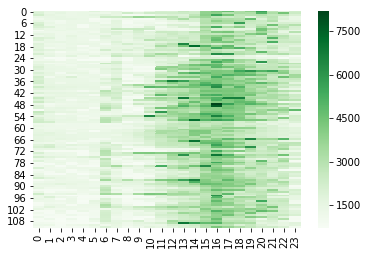

In [389]:
sns.heatmap(pd.DataFrame(test_aggregate[0][0]), cmap='Greens')

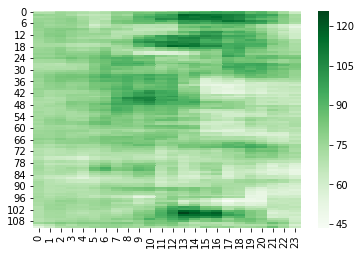

In [390]:
sns.heatmap(pd.DataFrame(test_fold[2000][5].reshape(-1, 112, 24)[10]), cmap='Greens')

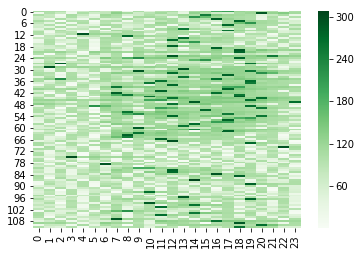

In [391]:
sns.heatmap(pd.DataFrame(test_gt_fold[5].reshape(-1, 112, 24)[10]), cmap='Greens')

In [392]:
pd.DataFrame(test_error).drop('residual').mean()

200      151.424384
400      122.590643
600      122.860904
800      123.342349
1000     122.276383
1200     122.030950
1400     121.685682
1600     120.899218
1800     120.070394
2000     119.556905
2200     118.989083
2400     118.280354
2600     117.348049
2800     117.012572
3000     116.449453
3200     116.409503
3400     115.825391
3600     116.020317
3800     115.695574
4000     115.903791
4200     115.784157
4400     115.794250
4600     115.499234
4800     115.743418
5000     115.619990
5200     115.538923
5400     115.414155
5600     115.588424
5800     115.748606
6000     115.262468
6200     115.183799
6400     115.376372
6600     115.218384
6800     115.220332
7000     115.223380
7200     115.475612
7400     115.454980
7600     115.381606
7800     115.311982
8000     115.225725
8200     114.874891
8400     115.082910
8600     115.084147
8800     115.075762
9000     115.136644
9200     115.213665
9400     114.860866
9600     114.701476
9800     115.096865
10000    115.202316


In [70]:
test_error

{1000: {'dr': 81.32205036373017,
  'dw': 22.031704636340837,
  'fridge': 36.054219562402324,
  'hvac': 359.29639448463996,
  'mw': 6.4345468134166639,
  'residual': 422.45171318107873},
 2000: {'dr': 81.280898478511673,
  'dw': 21.899984569587829,
  'fridge': 36.024768559812891,
  'hvac': 358.93100585771759,
  'mw': 6.5109258646896189,
  'residual': 422.17017752696739},
 3000: {'dr': 81.275294424102768,
  'dw': 22.039262022714173,
  'fridge': 36.068335926765535,
  'hvac': 359.18610809552092,
  'mw': 6.5118324969915022,
  'residual': 416.13323106903158},
 4000: {'dr': 81.366891872408686,
  'dw': 20.647875419210706,
  'fridge': 35.98414475870581,
  'hvac': 360.46443167746975,
  'mw': 6.5524279949693023,
  'residual': 421.61815515388588},
 5000: {'dr': 81.257931739263412,
  'dw': 21.756704200352942,
  'fridge': 36.051666488597853,
  'hvac': 359.81176352237964,
  'mw': 6.535311410560392,
  'residual': 419.94786840511989},
 6000: {'dr': 81.231062300794406,
  'dw': 21.842812423590402,
  'fri